In [1]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

In [ ]:
import os
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount("/content/drive")
DATA_ROOT = "/content/drive/MyDrive/college/AI for Conservation/Algae_v6"
required_folders = ["train", "valid", "test"]
for folder in required_folders:
    path = os.path.join(DATA_ROOT, folder, "_annotations.coco.json")
    if os.path.exists(path):
        print(f"Found annotations in {folder}")
    else:
        print(f"Could not find _annotations.coco.json in {folder}")

print(f"Dataset Path: {DATA_ROOT}")

✅ Found annotations in train
✅ Found annotations in valid
✅ Found annotations in test
Dataset Path: /content/drive/MyDrive/college/AI for Conservation/Algae_v6


Load data for further testing

In [ ]:
import os
import torch
from rfdetr import RFDETRMedium
import supervision as sv
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Paths
DATA_ROOT = "/content/drive/MyDrive/college/AI for Conservation/Algae_v6"
CKPT_DIR  = "/content/drive/MyDrive/college/AI for Conservation/rfdetr_weights"
CKPT_PATH = os.path.join(CKPT_DIR, "checkpoint_best_total.pth")

# load test set
test_dir = os.path.join(DATA_ROOT, "test")
test_json = os.path.join(test_dir, "_annotations.coco.json")

ds = sv.DetectionDataset.from_coco(
    images_directory_path=test_dir,
    annotations_path=test_json,
)

print(f"# test images: {len(ds)}")
print("Classes:", ds.classes)

# load pretrained weights from path
model = RFDETRMedium(
    pretrain_weights=CKPT_PATH,
    confidence_threshold=0.0
)
model.optimize_for_inference()


Device: cuda
# test images: 281
Classes: ['plants', 'Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing detection head with 18 classes
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Internal model device: cuda


In [ ]:
all_gts = []
all_preds = [] 

for path, _, gt in tqdm(ds, desc="Running model on test set"):
    img = Image.open(path).convert("RGB")
    detections = model.predict(img, threshold=0.0)  # keep all boxes
    all_gts.append(gt)
    all_preds.append(detections)

print("Collected predictions for", len(all_preds), "images.")


Running model on test set: 100%|██████████| 281/281 [03:40<00:00,  1.27it/s]

Collected predictions for 281 images.


In [ ]:
def box_iou_matrix(boxes1: np.ndarray, boxes2: np.ndarray) -> np.ndarray:
    """
    Define iou for bounding boxes
    """
    if len(boxes1) == 0 or len(boxes2) == 0:
        return np.zeros((len(boxes1), len(boxes2)), dtype=np.float32)

    x11, y11, x12, y12 = boxes1.T
    x21, y21, x22, y22 = boxes2.T

    xa1 = np.maximum(x11[:, None], x21[None, :])
    ya1 = np.maximum(y11[:, None], y21[None, :])
    xa2 = np.minimum(x12[:, None], x22[None, :])
    ya2 = np.minimum(y12[:, None], y22[None, :])

    inter_w = np.clip(xa2 - xa1, a_min=0, a_max=None)
    inter_h = np.clip(ya2 - ya1, a_min=0, a_max=None)
    inter = inter_w * inter_h

    area1 = (x12 - x11) * (y12 - y11)
    area2 = (x22 - x21) * (y22 - y21)

    union = area1[:, None] + area2[None, :] - inter
    return inter / np.clip(union, 1e-6, None)


In [ ]:
num_classes = len(ds.classes)

def evaluate_at_threshold(thr: float, iou_thr: float = 0.5):
    TP = FP = FN = 0

    for gts, preds in zip(all_gts, all_preds):
        gt_boxes = gts.xyxy
        gt_labels = gts.class_id

        # filter by confidecnce
        mask_conf = preds.confidence >= thr
        pred_boxes = preds.xyxy[mask_conf]
        pred_labels = preds.class_id[mask_conf]
        pred_scores = preds.confidence[mask_conf]

        for c in range(num_classes):
            # select GTs and preds for this class
            gidx = np.where(gt_labels == c)[0]
            pidx = np.where(pred_labels == c)[0]

            if len(gidx) == 0 and len(pidx) == 0:
                continue

            gt_used = np.zeros(len(gidx), dtype=bool)

            if len(pidx) > 0:
                # sort predictions of this class by confidence desc
                order = np.argsort(-pred_scores[pidx])

                for j in order:
                    pb = pred_boxes[pidx[j]][None, :]
                    if len(gidx) == 0:
                        # no GT for this class in this image
                        FP += 1
                        continue

                    ious = box_iou_matrix(gt_boxes[gidx], pb)[:, 0]
                    best_idx = int(np.argmax(ious))
                    best_iou = ious[best_idx]

                    if best_iou >= iou_thr and not gt_used[best_idx]:
                        TP += 1
                        gt_used[best_idx] = True
                    else:
                        FP += 1

            # any GT boxes not matched are false netgatives
            FN += int(len(gidx) - gt_used.sum())

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


In [ ]:
thresholds = np.linspace(0.0, 0.9, 19)  # 0.0, 0.05, ..., 0.9
precisions = []
recalls = []
f1s = []

for thr in thresholds:
    p, r, f1 = evaluate_at_threshold(thr, iou_thr=0.5)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)
    print(f"thr={thr:.2f} -> P={p:.3f}, R={r:.3f}, F1={f1:.3f}")


thr=0.00 -> P=0.023, R=0.908, F1=0.045
thr=0.05 -> P=0.045, R=0.904, F1=0.085
thr=0.10 -> P=0.097, R=0.861, F1=0.175
thr=0.15 -> P=0.167, R=0.799, F1=0.276
thr=0.20 -> P=0.262, R=0.718, F1=0.384
thr=0.25 -> P=0.364, R=0.632, F1=0.462
thr=0.30 -> P=0.469, R=0.547, F1=0.505
thr=0.35 -> P=0.575, R=0.470, F1=0.517
thr=0.40 -> P=0.652, R=0.392, F1=0.490
thr=0.45 -> P=0.728, R=0.323, F1=0.447
thr=0.50 -> P=0.781, R=0.260, F1=0.390
thr=0.55 -> P=0.837, R=0.199, F1=0.322
thr=0.60 -> P=0.858, R=0.147, F1=0.251
thr=0.65 -> P=0.865, R=0.099, F1=0.178
thr=0.70 -> P=0.895, R=0.064, F1=0.119
thr=0.75 -> P=0.917, R=0.036, F1=0.069
thr=0.80 -> P=0.923, R=0.011, F1=0.022
thr=0.85 -> P=1.000, R=0.002, F1=0.004
thr=0.90 -> P=0.000, R=0.000, F1=0.000


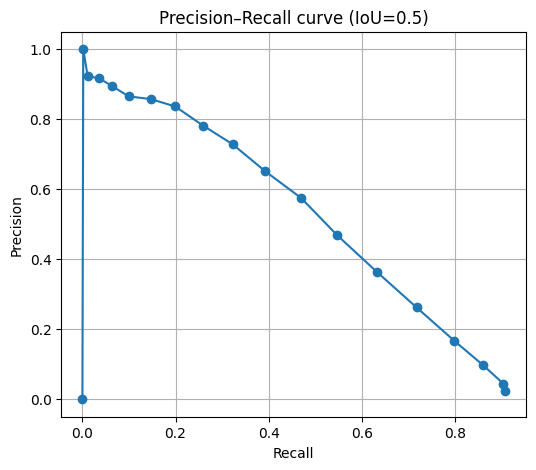

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, marker="o")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (IoU=0.5)")
plt.grid(True)
plt.show()


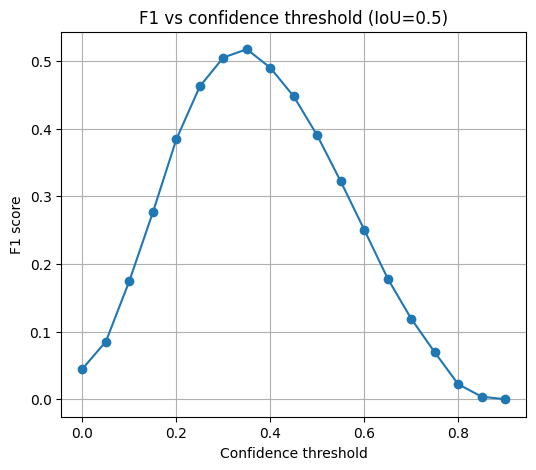

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(thresholds, f1s, marker="o")
plt.xlabel("Confidence threshold")
plt.ylabel("F1 score")
plt.title("F1 vs confidence threshold (IoU=0.5)")
plt.grid(True)
plt.show()


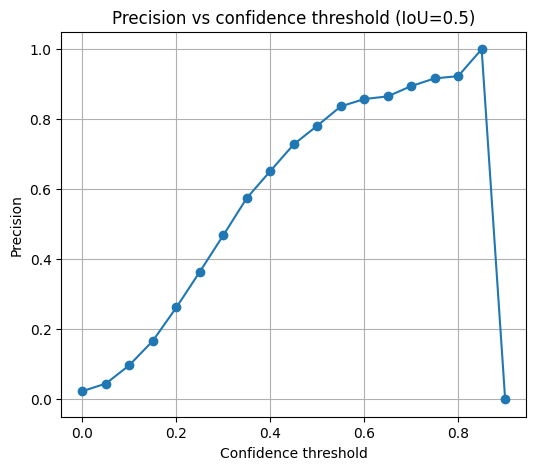

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(thresholds, precisions, marker="o")
plt.xlabel("Confidence threshold")
plt.ylabel("Precision")
plt.title("Precision vs confidence threshold (IoU=0.5)")
plt.grid(True)
plt.show()


In [ ]:
num_classes = len(ds.classes)
print("Num classes:", num_classes)
print("Classes:", ds.classes)

def evaluate_class_at_threshold(class_id: int, thr: float, iou_thr: float = 0.5):
    """
    Compute precision, recall, F1 for a SINGLE class at a given confidence threshold
    based on the above function for all classes
    """
    TP = FP = FN = 0

    for gts, preds in zip(all_gts, all_preds):
        gt_boxes = gts.xyxy
        gt_labels = gts.class_id

        # filter predictions by threshold
        mask_conf = preds.confidence >= thr
        pred_boxes = preds.xyxy[mask_conf]
        pred_labels = preds.class_id[mask_conf]
        pred_scores = preds.confidence[mask_conf]

        # select GT and predicted boxes of this class
        gidx = np.where(gt_labels == class_id)[0]
        pidx = np.where(pred_labels == class_id)[0]

        # no GT and no preds for this class in this image
        if len(gidx) == 0 and len(pidx) == 0:
            continue

        gt_used = np.zeros(len(gidx), dtype=bool)

        if len(pidx) > 0:
            # sort predictions of this class by confidence desc
            order = np.argsort(-pred_scores[pidx])

            for j in order:
                pb = pred_boxes[pidx[j]][None, :]
                if len(gidx) == 0:
                    # no GT of this class in this image
                    FP += 1
                    continue

                ious = box_iou_matrix(gt_boxes[gidx], pb)[:, 0]
                best_idx = int(np.argmax(ious))
                best_iou = ious[best_idx]

                if best_iou >= iou_thr and not gt_used[best_idx]:
                    TP += 1
                    gt_used[best_idx] = True
                else:
                    FP += 1

        # any GT of this class in this image not matched are false netgatives
        FN += int(len(gidx) - gt_used.sum())

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


Num classes: 19
Classes: ['plants', 'Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']


In [ ]:
thresholds = np.linspace(0.0, 0.9, 19) 

# show how many GT examples exist
gt_counts = np.zeros(num_classes, dtype=int)
for gts in all_gts:
    labels = gts.class_id
    for c in range(num_classes):
        gt_counts[c] += np.sum(labels == c)

print("GT counts per class:")
for c, name in enumerate(ds.classes):
    print(f"{c:2d} ({name}): {gt_counts[c]}")

# pick classes that exist in GT only
class_ids_with_gt = [c for c in range(num_classes) if gt_counts[c] > 0]
print("Classes with GT in test:", [ds.classes[c] for c in class_ids_with_gt])


GT counts per class:
 0 (plants): 0
 1 (Algae): 145
 2 (Clam Shell): 94
 3 (Elodea Canadensis): 20
 4 (Eriocaulon Septangulare): 292
 5 (I. Lacustris): 0
 6 (Leaves): 41
 7 (M. Spicatum): 22
 8 (M. Tenellum): 3
 9 (Najas): 18
10 (P. Amplifolius): 1062
11 (P. Gramineus): 42
12 (P. Perfoliatus): 28
13 (P. Praelongus): 79
14 (P. Robbinsii): 177
15 (P. Zosteriformis): 37
16 (Snail): 6
17 (Unknown Plant): 61
18 (Vallisneria Americana): 7
Classes with GT in test: ['Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']


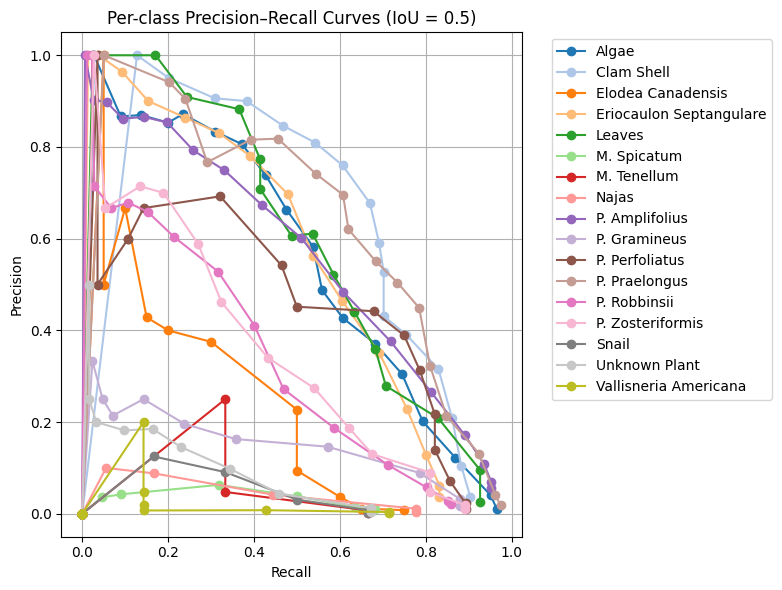

In [ ]:
plt.figure(figsize=(8, 6))

cmap = plt.get_cmap("tab20")

for idx, class_id in enumerate(class_ids_with_gt):
    class_name = ds.classes[class_id]

    cls_precisions = []
    cls_recalls = []

    for thr in thresholds:
        p, r, f1 = evaluate_class_at_threshold(class_id, thr, iou_thr=0.5)
        cls_precisions.append(p)
        cls_recalls.append(r)

    cls_precisions = np.array(cls_precisions)
    cls_recalls = np.array(cls_recalls)
    color = cmap(idx % 20)
    plt.plot(cls_recalls, cls_precisions, marker="o", color=color, label=class_name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Per-class Precision–Recall Curves (IoU = 0.5)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


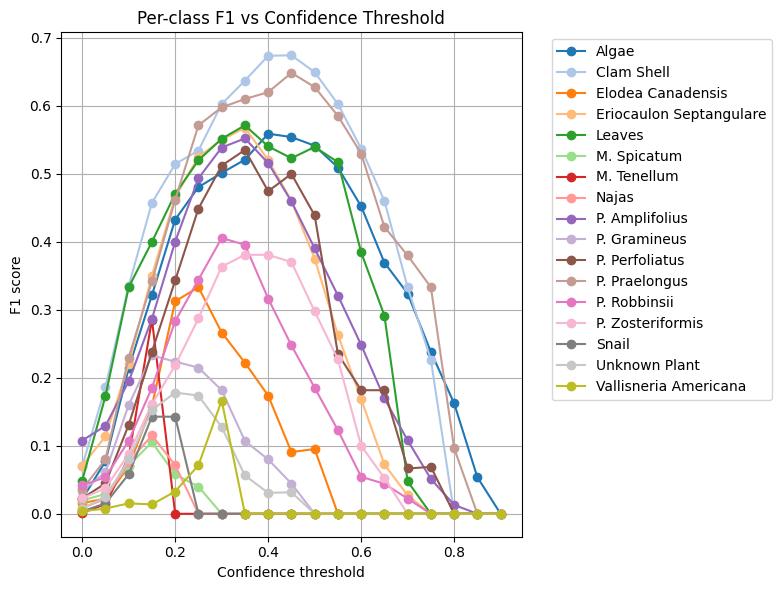

In [ ]:
plt.figure(figsize=(8, 6))

for idx, class_id in enumerate(class_ids_with_gt):
    class_name = ds.classes[class_id]

    cls_f1s = []
    for thr in thresholds:
        p, r, f1 = evaluate_class_at_threshold(class_id, thr, iou_thr=0.5)
        cls_f1s.append(f1)

    color = cmap(idx % 20)
    plt.plot(thresholds, cls_f1s, marker="o", color=color, label=class_name)

plt.xlabel("Confidence threshold")
plt.ylabel("F1 score")
plt.title("Per-class F1 vs Confidence Threshold")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Loaded 19 classes: ['plants', 'Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']

--- Visualizing Predictions ---
Prediction for: frame25_25100ms_jpg.rf.b0cfca98c44edd9f9ef5e28470946fd3.jpg


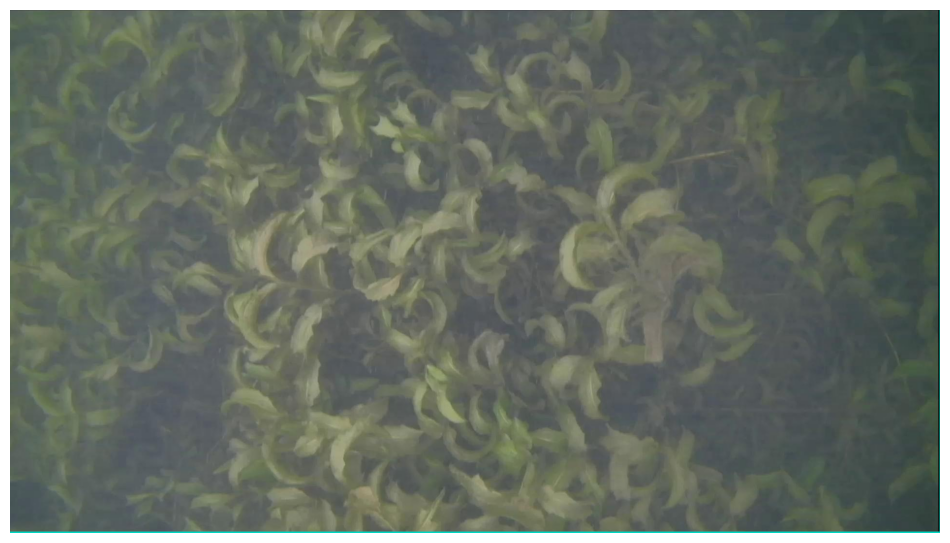

Prediction for: frame302_305566ms_jpg.rf.db34e92bb97147217573692d477c6d34.jpg


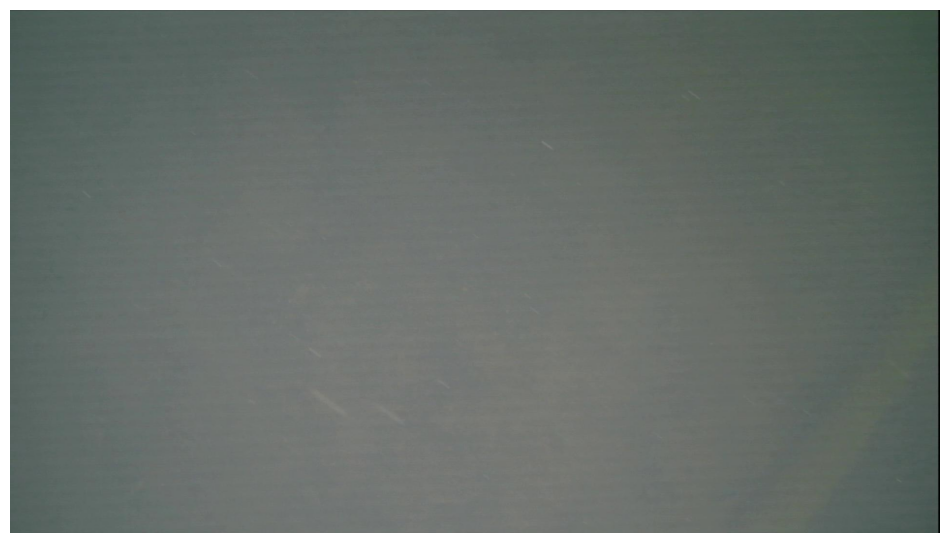

Prediction for: frame255_255966ms_jpg.rf.a75518c80b51b927a6ae76a044ecd661.jpg


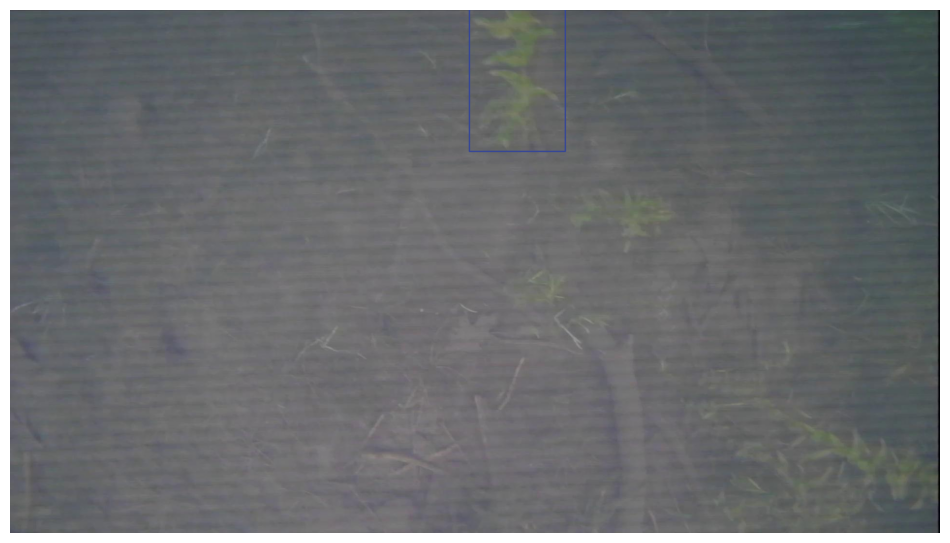


--- Starting Full Evaluation ---
Calculating per-image presence/absence...


100%|██████████| 281/281 [00:23<00:00, 11.98it/s]



=== Per-Species Presence/Absence Report ===
Precision: When model claims species X is present, how often is it right?
Recall:    When species X is actually present, how often does model find it?
------------------------------------------------------------
                         precision    recall  f1-score   support

                 plants       0.00      0.00      0.00         0
                  Algae       0.87      0.59      0.70        34
             Clam Shell       1.00      0.77      0.87        30
      Elodea Canadensis       1.00      0.10      0.18        10
Eriocaulon Septangulare       1.00      0.40      0.57        20
           I. Lacustris       0.00      0.00      0.00         0
                 Leaves       1.00      0.44      0.62         9
            M. Spicatum       1.00      0.14      0.25         7
            M. Tenellum       0.00      0.00      0.00         2
                  Najas       0.00      0.00      0.00         9
         P. Amplifolius    

In [ ]:
# Visualization Function
def visualize_random_prediction(model, dataset_root, num_images=3):
    print("\n--- Visualizing Predictions ---")
    test_images = glob.glob(os.path.join(dataset_root, "test", "*.jpg"))

    if not test_images:
        print("No images found in test folder.")
        return

    for _ in range(num_images):
        image_path = random.choice(test_images)
        image = Image.open(image_path).convert("RGB")

        # RF-DETR .predict() returns a supervision "Detections" object
        detections = model.predict(image, confidence=0.4, overlap=0.5)

        # Create labels using CLASS_NAMES list instead of index number
        labels = [
            f"{CLASS_NAMES[class_id]} {confidence:.2f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]

        # Annotate
        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        annotated_image = image.copy()
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

        print(f"Prediction for: {os.path.basename(image_path)}")
        sv.plot_image(annotated_image)

# Evaluation Function for per image species presence/absence
def evaluate_test_set(model, dataset_root):
    print("\n--- Starting Full Evaluation ---")

    test_ds = sv.DetectionDataset.from_coco(
        images_directory_path=os.path.join(dataset_root, "test"),
        annotations_path=os.path.join(dataset_root, "test", "_annotations.coco.json")
    )
    print("Calculating per-image presence/absence...")
    y_true = []
    y_pred = []

    # iterate over annotation keys
    image_names = list(test_ds.annotations.keys())

    for img_name in tqdm(image_names):
        gt_detections = test_ds.annotations[img_name]
        gt_classes = set(gt_detections.class_id)
        img_path = os.path.join(dataset_root, "test", img_name)
        if not os.path.exists(img_path):
            continue # if missing file

        pil_img = Image.open(img_path).convert("RGB")
        pred_detections = model.predict(pil_img, confidence=0.4)
        pred_classes = set(pred_detections.class_id)

        # Create Binary Vectors for scikit-learn presence/absence
        gt_vector = [1 if i in gt_classes else 0 for i in range(len(CLASS_NAMES))]
        pred_vector = [1 if i in pred_classes else 0 for i in range(len(CLASS_NAMES))]

        y_true.append(gt_vector)
        y_pred.append(pred_vector)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n=== Per-Species Presence/Absence Report ===")
    print("Precision: When model claims species X is present, how often is it right?")
    print("Recall:    When species X is actually present, how often does model find it?")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))


visualize_random_prediction(model, DATA_ROOT, num_images=3)
evaluate_test_set(model, DATA_ROOT)

--- Per-Class Bounding Box Metrics (IoU=0.5, Conf=0.35) ---

Results per Class:
+-------------------------+-----------------+--------------+----------+--------------------+
|        Class Name       | Precision (Box) | Recall (Box) | F1-Score | Support (GT Boxes) |
+-------------------------+-----------------+--------------+----------+--------------------+
|          plants         |       0.00      |     0.00     |   0.00   |         0          |
|          Algae          |       0.69      |     0.19     |   0.29   |        145         |
|        Clam Shell       |       0.84      |     0.38     |   0.53   |         94         |
|    Elodea Canadensis    |       0.00      |     0.00     |   0.00   |         20         |
| Eriocaulon Septangulare |       0.87      |     0.23     |   0.36   |        292         |
|       I. Lacustris      |       0.00      |     0.00     |   0.00   |         0          |
|          Leaves         |       0.70      |     0.34     |   0.46   |         41 

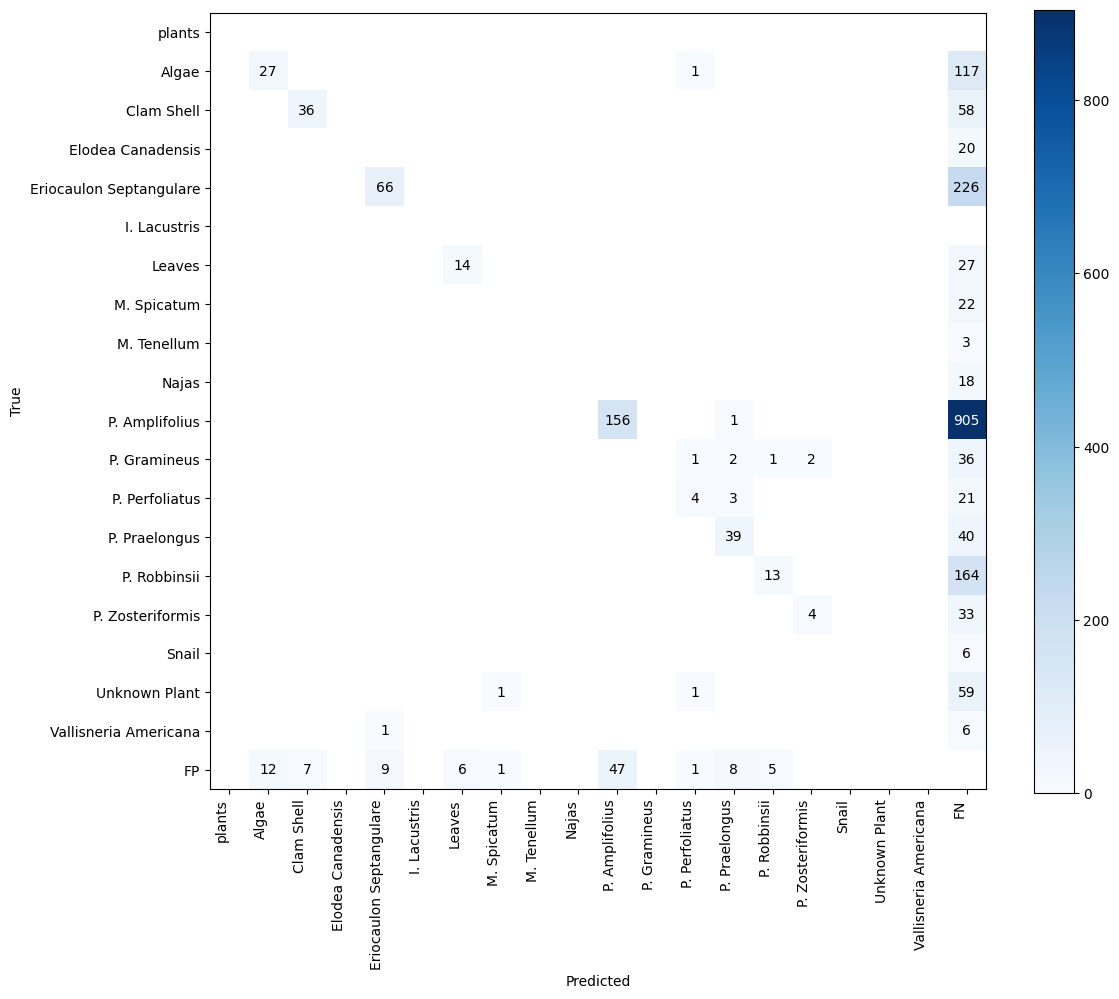

In [ ]:
from prettytable import PrettyTable

# evaluating bounding box accuracy per-class
def evaluate_bbox_per_class(model, dataset_root, confidence_threshold=0.4, iou_threshold=0.5):
    print(f"--- Per-Class Bounding Box Metrics (IoU={iou_threshold}, Conf={confidence_threshold}) ---")

    test_ds = sv.DetectionDataset.from_coco(
        images_directory_path=os.path.join(dataset_root, "test"),
        annotations_path=os.path.join(dataset_root, "test", "_annotations.coco.json")
    )
    def callback(image: np.ndarray) -> sv.Detections:
        return model.predict(Image.fromarray(image), confidence=confidence_threshold)

    # Compute Confusion Matrix:
    # matching predictions to ground truth boxes based on IoU
    cm = sv.ConfusionMatrix.benchmark(
        dataset=test_ds,
        callback=callback,
        conf_threshold=confidence_threshold,
        iou_threshold=iou_threshold
    )

    # Extract Metrics per Class
    matrix = cm.matrix

    table = PrettyTable()
    table.field_names = ["Class Name", "Precision (Box)", "Recall (Box)", "F1-Score", "Support (GT Boxes)"]

    print("\nResults per Class:")

    for i, class_name in enumerate(CLASS_NAMES):
        # True positives on the diagonal
        tp = matrix[i, i]

        # False Positives columnb sum
        fp = matrix[:, i].sum() - tp

        # False Negatives row sum
        fn = matrix[i, :].sum() - tp

        # Support (number of ground truth boxes present fo rthis class)
        support = matrix[i, :].sum()

        #metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        table.add_row([
            class_name,
            f"{precision:.2f}",
            f"{recall:.2f}",
            f"{f1:.2f}",
            int(support)
        ])

    print(table)

    # plot confusinon matrix (per class bounding box)
    cm.plot(classes=CLASS_NAMES, normalize=False)
    plt.show()

evaluate_bbox_per_class(model, DATA_ROOT, confidence_threshold=0.35, iou_threshold=0.5)

In [ ]:
# loading class names in to fix the weird "plants" class issue
with open(train_json_path, 'r') as f:
    data = json.load(f)
    sorted_cats = sorted(data['categories'], key=lambda x: x['id'])
    CLASS_NAMES = [cat['name'] for cat in sorted_cats]

print(f"Loaded {len(CLASS_NAMES)} classes: {CLASS_NAMES}")# After CLASS_NAMES is defined
print(f"Loaded {len(CLASS_NAMES)} classes: {CLASS_NAMES}")

# class names to ignore in evlauation
IGNORED_CLASS_NAMES = {"plants"} 

ACTIVE_CLASS_INDICES = [
    i for i, name in enumerate(CLASS_NAMES)
    if name not in IGNORED_CLASS_NAMES
]
ACTIVE_CLASS_NAMES = [CLASS_NAMES[i] for i in ACTIVE_CLASS_INDICES]

print("Evaluating on these classes:", ACTIVE_CLASS_NAMES)


Loaded 19 classes: ['plants', 'Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']
Loaded 19 classes: ['plants', 'Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']
Evaluating on these classes: ['Algae', 'Clam Shell', 'Elodea Canadensis', 'Eriocaulon Septangulare', 'I. Lacustris', 'Leaves', 'M. Spicatum', 'M. Tenellum', 'Najas', 'P. Amplifolius', 'P. Gramineus', 'P. Perfoliatus', 'P. Praelongus', 'P. Robbinsii', 'P. Zosteriformis', 'Snail', 'Unknown Plant', 'Vallisneria Americana']


In [ ]:
def visualize_random_prediction(model, dataset_root, num_images=3):
    print("\n--- Visualizing Predictions ---")
    test_images = glob.glob(os.path.join(dataset_root, "test", "*.jpg"))

    if not test_images:
        print("No images found in test folder.")
        return

    for _ in range(num_images):
        image_path = random.choice(test_images)
        image = Image.open(image_path).convert("RGB")

        # RF-DETR .predict() returns a supervision "Detections" object
        detections = model.predict(image, confidence=0.4, overlap=0.5)

        # Create labels using CLASS_NAMES list 
        labels = [
            f"{CLASS_NAMES[class_id]} {confidence:.2f}"
            for class_id, confidence
            in zip(detections.class_id, detections.confidence)
        ]

        # Annotate
        box_annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()

        annotated_image = image.copy()
        annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

        print(f"Prediction for: {os.path.basename(image_path)}")
        sv.plot_image(annotated_image)

In [ ]:
from sklearn.metrics import classification_report

def evaluate_test_set(model, dataset_root):
    print("\n--- Starting Full Evaluation ---")

    test_ds = sv.DetectionDataset.from_coco(
        images_directory_path=os.path.join(dataset_root, "test"),
        annotations_path=os.path.join(dataset_root, "test", "_annotations.coco.json")
    )
    print("Calculating per-image presence/absence...")
    y_true = []
    y_pred = []

    image_names = list(test_ds.annotations.keys())

    for img_name in tqdm(image_names):
        # Ground truth
        gt_detections = test_ds.annotations[img_name]
        gt_classes = set(gt_detections.class_id)

        img_path = os.path.join(dataset_root, "test", img_name)
        if not os.path.exists(img_path):
            continue

        pil_img = Image.open(img_path).convert("RGB")

        # Predictions
        pred_detections = model.predict(pil_img, confidence=0.2)
        pred_classes = set(pred_detections.class_id)

        # Presence vectors over active indeces
        gt_vector = [1 if idx in gt_classes else 0 for idx in ACTIVE_CLASS_INDICES]
        pred_vector = [1 if idx in pred_classes else 0 for idx in ACTIVE_CLASS_INDICES]

        y_true.append(gt_vector)
        y_pred.append(pred_vector)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print("\n=== Per-Species Presence/Absence Report (filtered) ===")
    print("Precision: When model claims species X is present, how often is it right?")
    print("Recall:    When species X is actually present, how often does model find it?")
    print("-" * 60)
    print(
        classification_report(
            y_true,
            y_pred,
            target_names=ACTIVE_CLASS_NAMES,
            zero_division=0
        )
    )

    return y_true, y_pred



--- Visualizing Predictions ---
Prediction for: frame306_309600ms_jpg.rf.5cbdee166a5e590c79c4ebfde8def40b.jpg


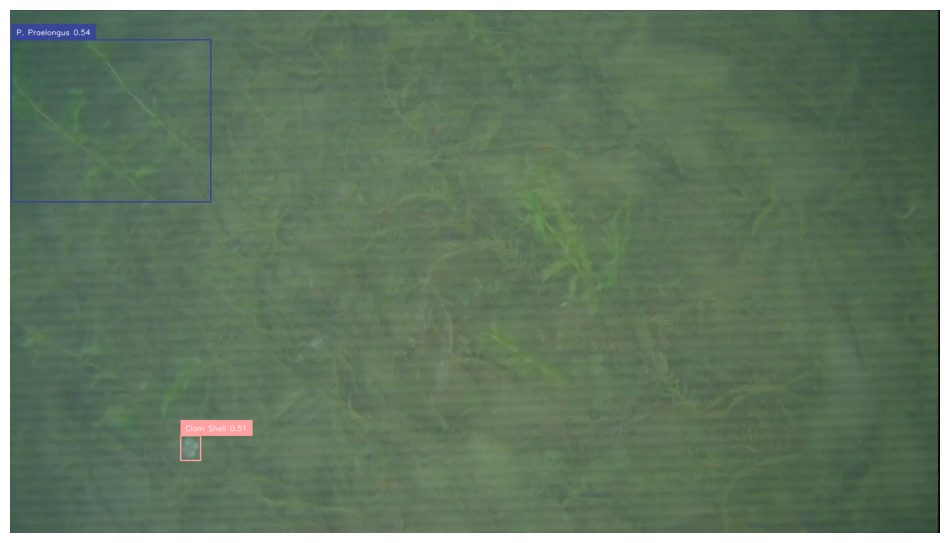

Prediction for: frame162_162966ms_jpg.rf.ec01b4321b6a2a7f66cd8e3f7aa3dff3.jpg


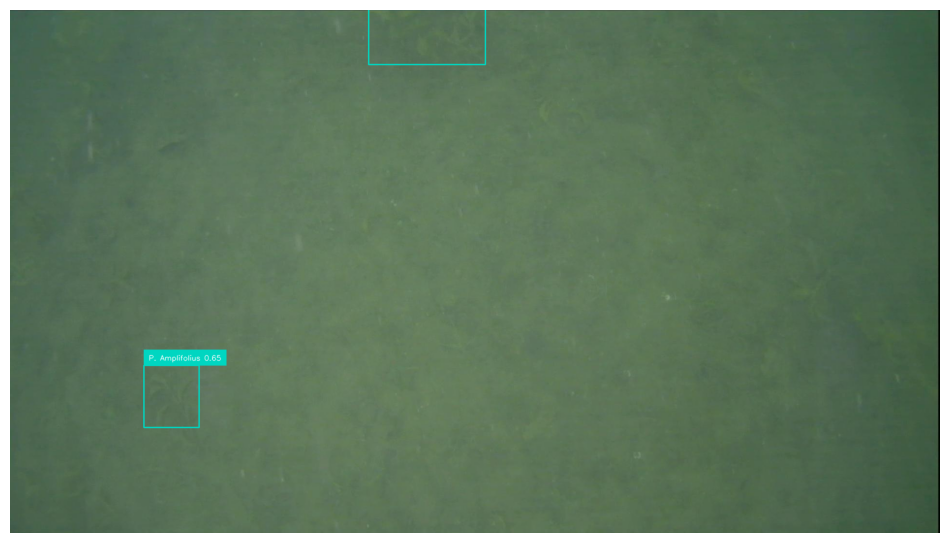

Prediction for: frame117_117966ms_jpg.rf.6c1d23e46e3820f14fece35bf440363f.jpg


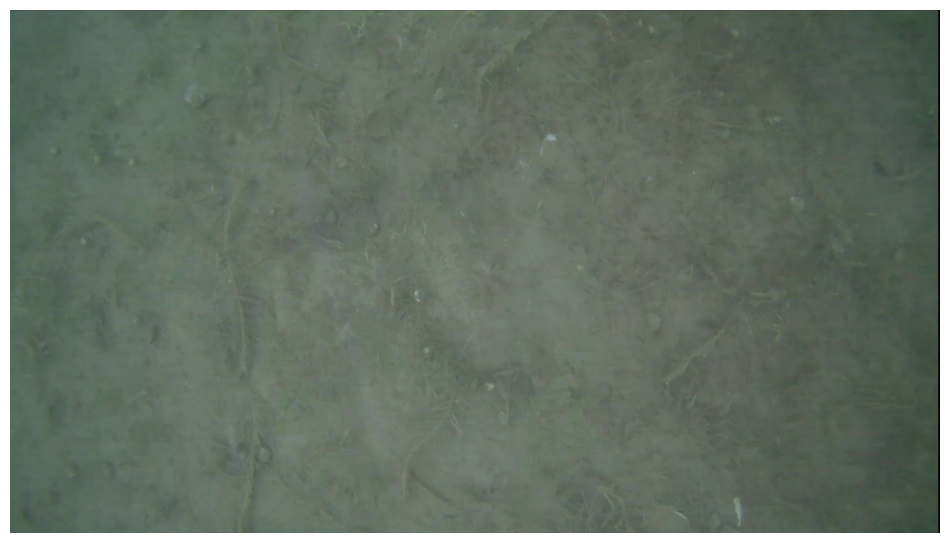


--- Starting Full Evaluation ---
Calculating per-image presence/absence...


100%|██████████| 281/281 [00:22<00:00, 12.26it/s]


=== Per-Species Presence/Absence Report (filtered) ===
Precision: When model claims species X is present, how often is it right?
Recall:    When species X is actually present, how often does model find it?
------------------------------------------------------------
                         precision    recall  f1-score   support

                  Algae       0.87      0.59      0.70        34
             Clam Shell       1.00      0.77      0.87        30
      Elodea Canadensis       1.00      0.10      0.18        10
Eriocaulon Septangulare       1.00      0.40      0.57        20
           I. Lacustris       0.00      0.00      0.00         0
                 Leaves       1.00      0.44      0.62         9
            M. Spicatum       1.00      0.14      0.25         7
            M. Tenellum       0.00      0.00      0.00         2
                  Najas       0.00      0.00      0.00         9
         P. Amplifolius       0.95      0.79      0.86        99
           P. Gr

In [22]:
visualize_random_prediction(model, DATA_ROOT, num_images=3)
y_true, y_pred = evaluate_test_set(model, DATA_ROOT)
